In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Supervised Learning (Linear)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

# Statistical Machine Learning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, roc_auc_score, roc_curve

pd.set_option('display.max_rows', 20)

# Data Loading

In [2]:
train = pd.read_csv('churn_sim_train.csv', delimiter=';')
test = pd.read_csv('churn_sim_test.csv', delimiter=';')
test.drop(columns=['leave'], inplace=True)

# Basic Understanding of the Data

### Shape of the Data

In [3]:
print(f'Train shape: {train.shape}')
print(f'Test shape: {test.shape}')

Train shape: (9868, 12)
Test shape: (4521, 11)


### Dataframe

In [4]:
train.head()

,college,income,overage,leftover,house,handset_price,over_15mins_calls_per_month,average_call_duration,reported_satisfaction,reported_usage_level,considering_change_of_plan,leave
0,one,88016,0,11,640773,280,17,4,very_sat,little,never_thought,False
1,zero,54688,0,14,381547,264,1,6,unsat,very_little,considering,False
2,zero,153846,168,67,485073,733,10,2,unsat,very_little,actively_looking_into_it,True
3,one,68591,62,71,573771,362,4,2,very_unsat,little,actively_looking_into_it,True
4,zero,66257,0,0,216566,272,1,13,very_unsat,very_little,perhaps,False


In [5]:
test.head()

,college,income,overage,leftover,house,handset_price,over_15mins_calls_per_month,average_call_duration,reported_satisfaction,reported_usage_level,considering_change_of_plan
0,one,132729,245,0,975834,319,21,10,avg,avg,actively_looking_into_it
1,zero,69823,0,13,874868,334,1,6,unsat,little,actively_looking_into_it
2,zero,75842,206,0,187501,298,21,13,very_sat,avg,no
3,zero,37311,173,19,710545,150,16,5,unsat,little,actively_looking_into_it
4,one,50281,52,0,298560,170,4,12,very_sat,little,considering


### Duplicates of the Data

In [6]:
print(f'Duplicates in the train data: {train.duplicated().sum()}, ({100*train.duplicated().sum() / len(train)}%)')
print(f'Duplicates in the train data: {train.duplicated().sum()}, ({100*train.duplicated().sum() / len(train)}%)')

Duplicates in the train data: 0, (0.0%)
Duplicates in the train data: 0, (0.0%)


### Data-Types of the Data

In [7]:
print(f'Train Data-Types:\n{train.dtypes}')
print('---------------------------------------')
print(f'Test Data-Types:\n{test.dtypes}')

Train Data-Types:
college                        object
income                          int64
overage                         int64
leftover                        int64
house                           int64
handset_price                   int64
over_15mins_calls_per_month     int64
average_call_duration           int64
reported_satisfaction          object
reported_usage_level           object
considering_change_of_plan     object
leave                            bool
dtype: object
---------------------------------------
Test Data-Types:
college                        object
income                          int64
overage                         int64
leftover                        int64
house                           int64
handset_price                   int64
over_15mins_calls_per_month     int64
average_call_duration           int64
reported_satisfaction          object
reported_usage_level           object
considering_change_of_plan     object
dtype: object


### Missing values of the Data

In [8]:
df1 = (train.isnull().sum()[train.isnull().sum() > 0]).to_frame().rename(columns={0: 'Number of missing values'})
df1['% of missing values'] = round((100*train.isnull().sum()[train.isnull().sum()>0] / len(train)), 2)
df1

,Number of missing values,% of missing values


In [9]:
df2 = (test.isnull().sum()[test.isnull().sum() > 0]).to_frame().rename(columns={0: 'Number of missing values'})
df2['% of missing values'] = round((100*test.isnull().sum()[test.isnull().sum()>0] / len(test)), 2)
df2

,Number of missing values,% of missing values


### Data Cardinality

In [10]:
print('Cardinality of categorical features in train data:')
print(train.select_dtypes(include='object').nunique())
print('\n'+'-'*50)
print('Cardinality of categorical features in test data:')
print(test.select_dtypes(include='object').nunique())

Cardinality of categorical features in train data:
college                       2
reported_satisfaction         5
reported_usage_level          5
considering_change_of_plan    5
dtype: int64

--------------------------------------------------
Cardinality of categorical features in test data:
college                       2
reported_satisfaction         5
reported_usage_level          5
considering_change_of_plan    5
dtype: int64


# Exploratory Data Analysis

### Visualizing Target Feautre "leave"

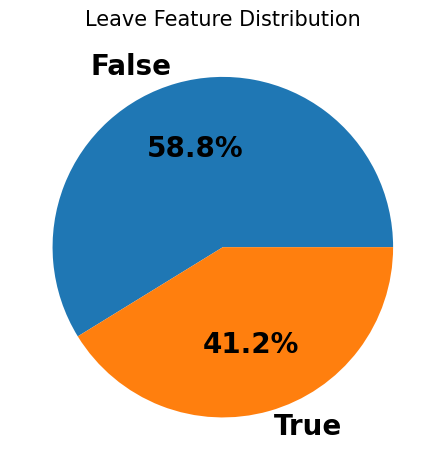

In [11]:
plt.figure()
plt.pie(train['leave'].value_counts(), labels=train['leave'].value_counts().keys(), autopct='%1.1f%%',
       textprops={'fontsize': 20, 'fontweight': 'black'})
plt.title('Leave Feature Distribution', size=15)

plt.tight_layout()
plt.show()

### Visualizing numerical features

In [12]:
train.select_dtypes(include='int').columns

Index(['income', 'overage', 'leftover', 'house', 'handset_price',
       'over_15mins_calls_per_month', 'average_call_duration'],
      dtype='object')

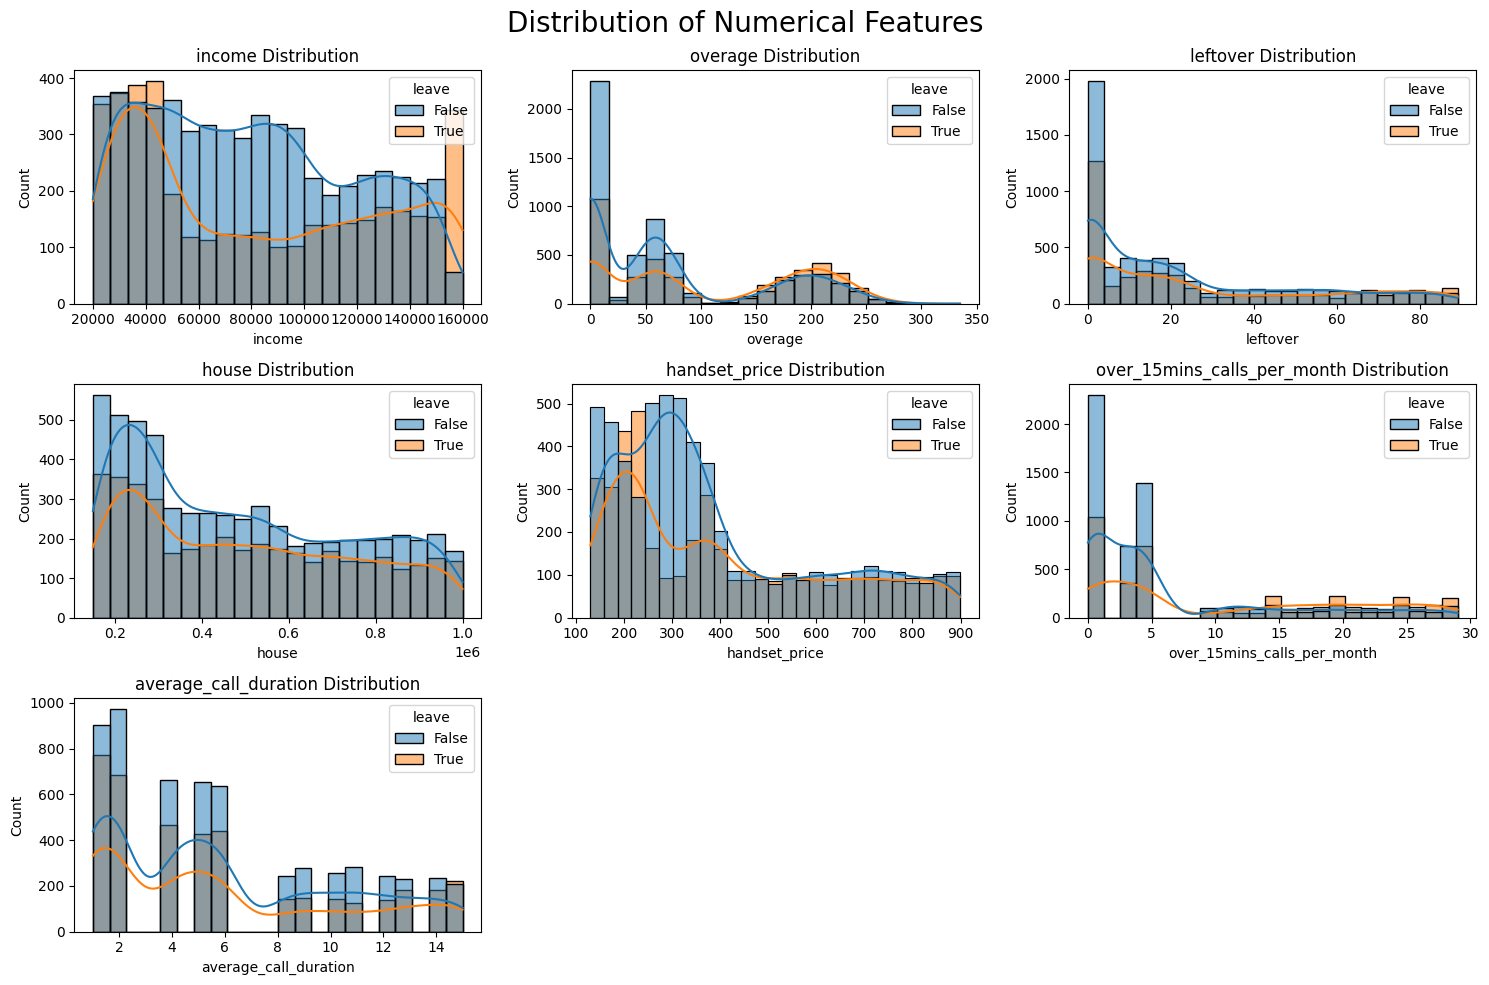

In [13]:
int_cols = ['income', 'overage', 'leftover', 'house', 'handset_price',
            'over_15mins_calls_per_month', 'average_call_duration']

plt.figure(figsize=(15, 10))
plt.suptitle('Distribution of Numerical Features', size=20)
for idx, column in enumerate(int_cols):
    plt.subplot(3, 3, idx+1)
    sns.histplot(x=column, hue='leave', data=train, kde=True)
    plt.title(f'{column} Distribution')

plt.tight_layout()
plt.show()

### Visualizing Categorical Features

In [14]:
train.select_dtypes(include=['object']).columns

Index(['college', 'reported_satisfaction', 'reported_usage_level',
       'considering_change_of_plan'],
      dtype='object')

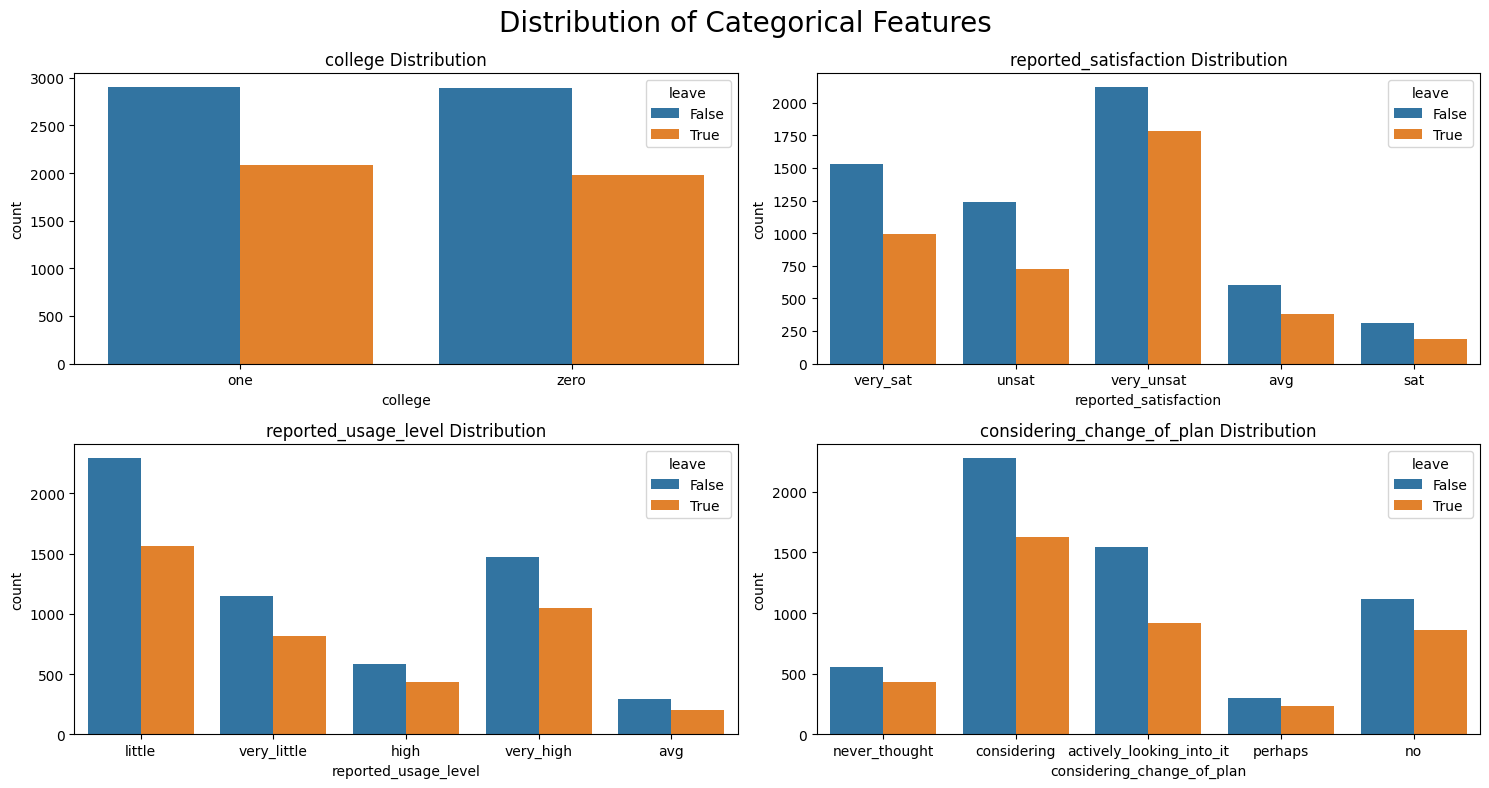

In [15]:
cat_cols = ['college', 'reported_satisfaction', 'reported_usage_level', 'considering_change_of_plan']

plt.figure(figsize=(15, 8))
plt.suptitle('Distribution of Categorical Features', size=20)
for idx, column in enumerate(cat_cols):
    plt.subplot(2, 2, idx+1)
    sns.countplot(x=column, hue='leave', data=train)
    plt.title(f'{column} Distribution')

plt.tight_layout()
plt.show()

# Feature Engineering

### reported_satisfaction Feature

In [16]:
train['reported_satisfaction'].value_counts().to_frame()

,count
reported_satisfaction,
very_unsat,3900
very_sat,2525
unsat,1967
avg,978
sat,498


In [17]:
def satisfaction(df):
    satisfaction = []
    for i in df['reported_satisfaction']:
        if i == 'very_sat' or i == 'sat':
            satisfaction.append('satisfied')
        elif i == 'avg':
            satisfaction.append('average')
        else:
            satisfaction.append('unsatisfied')

    df['satisfaction'] = satisfaction

In [18]:
satisfaction(train)
satisfaction(test)

### Visualizing "satisfaction" Feature

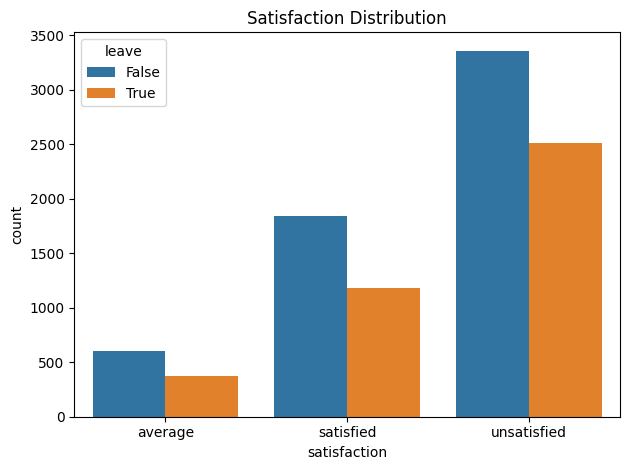

In [19]:
order = sorted(train['satisfaction'].value_counts().keys().to_list())

plt.figure()
sns.countplot(x='satisfaction', hue='leave', data=train, order=order)
plt.title('Satisfaction Distribution')

plt.tight_layout()
plt.show()

### reported_usage_level Feature

In [20]:
train['reported_usage_level'].value_counts().to_frame()

,count
reported_usage_level,
little,3860
very_high,2522
very_little,1965
high,1021
avg,500


In [21]:
def usage_level(df):
    usage_level = []
    for i in df['reported_usage_level']:
        if i == 'very_high' or i == 'high':
            usage_level.append('high')
        elif i == 'avg':
            usage_level.append('average')
        else:
            usage_level.append('low')

    df['usage_level'] = usage_level

In [22]:
usage_level(train)
usage_level(test)

### Visualizing "usage_level" Feature

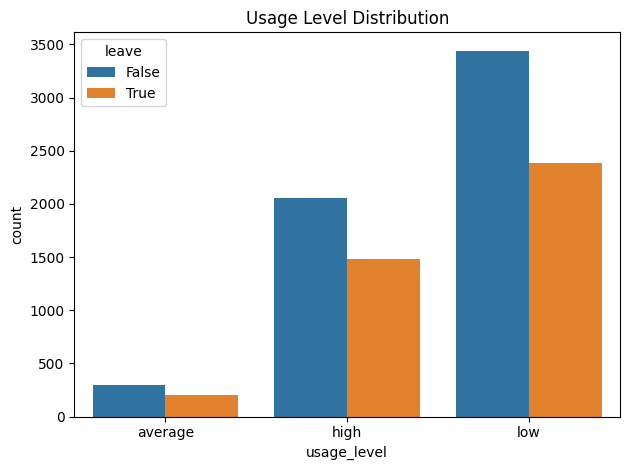

In [23]:
order = sorted(train['usage_level'].value_counts().keys().to_list())

plt.figure()
sns.countplot(x='usage_level', hue='leave', data=train, order=order)
plt.title('Usage Level Distribution')

plt.tight_layout()
plt.show()

### considering_change_of_plan Feature

In [24]:
train['considering_change_of_plan'].value_counts().to_frame()

,count
considering_change_of_plan,
considering,3904
actively_looking_into_it,2465
no,1980
never_thought,984
perhaps,535


In [25]:
def change_of_plan(df):
    change_of_plan = []
    for i in df['considering_change_of_plan']:
        if i == 'never_thought' or i == 'no':
            change_of_plan.append('no_plan')
        elif i == 'perhaps':
            change_of_plan.append('average')
        else:
            change_of_plan.append('considering')

    df['change_of_plan'] = change_of_plan

In [26]:
change_of_plan(train)
change_of_plan(test)

### Visualizing "change_of_plan" Feature

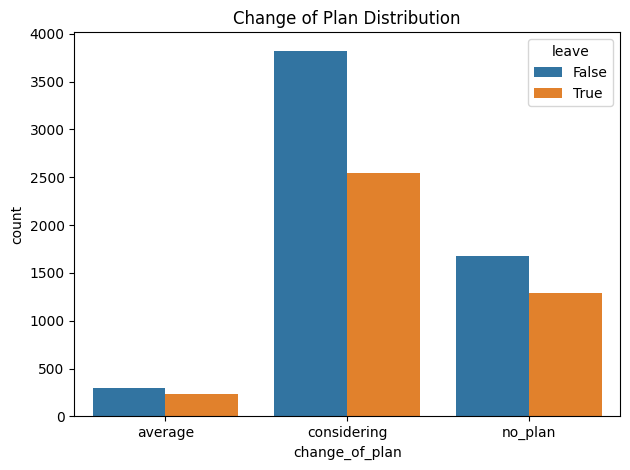

In [27]:
order = sorted(train['change_of_plan'].value_counts().keys().to_list())

plt.figure()
sns.countplot(data=train, x='change_of_plan', hue='leave', order=order)
plt.title('Change of Plan Distribution')

plt.tight_layout()
plt.show()

## Dropping unnecessary columns

In [28]:
cols = ['reported_satisfaction', 'reported_usage_level', 'considering_change_of_plan']

train.drop(columns=cols, inplace=True)
test.drop(columns=cols, inplace=True)

## Statistical Information

In [29]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
income,9868.0,80554.467977,41883.843724,20012.0,42272.25,75771.0,117195.75,159954.0
overage,9868.0,86.544082,86.509895,0.0,0.00,59.0,180.00,335.0
leftover,9868.0,24.441832,27.161554,0.0,0.00,15.0,42.25,89.0
house,9868.0,493650.917815,252532.162618,150066.0,264456.00,453495.5,704687.25,999996.0
handset_price,9868.0,389.481861,214.728405,130.0,218.00,325.0,533.00,899.0
over_15mins_calls_per_month,9868.0,8.043981,8.982618,0.0,1.00,4.0,15.00,29.0
average_call_duration,9868.0,5.969700,4.401276,1.0,2.00,5.0,9.00,15.0


## One Hot Encoding

In [30]:
train.head()

,college,income,overage,leftover,house,handset_price,over_15mins_calls_per_month,average_call_duration,leave,satisfaction,usage_level,change_of_plan
0,one,88016,0,11,640773,280,17,4,False,satisfied,low,no_plan
1,zero,54688,0,14,381547,264,1,6,False,unsatisfied,low,considering
2,zero,153846,168,67,485073,733,10,2,True,unsatisfied,low,considering
3,one,68591,62,71,573771,362,4,2,True,unsatisfied,low,considering
4,zero,66257,0,0,216566,272,1,13,False,unsatisfied,low,average


In [31]:
one_cols = ['satisfaction', 'usage_level', 'change_of_plan']

train = pd.get_dummies(train, columns=one_cols, dtype=int, drop_first=True)
test = pd.get_dummies(test, columns=one_cols, dtype=int, drop_first=True)

In [32]:
train

,college,income,overage,leftover,house,handset_price,over_15mins_calls_per_month,average_call_duration,leave,satisfaction_satisfied,satisfaction_unsatisfied,usage_level_high,usage_level_low,change_of_plan_considering,change_of_plan_no_plan
0,one,88016,0,11,640773,280,17,4,False,1,0,0,1,0,1
1,zero,54688,0,14,381547,264,1,6,False,0,1,0,1,1,0
2,zero,153846,168,67,485073,733,10,2,True,0,1,0,1,1,0
3,one,68591,62,71,573771,362,4,2,True,0,1,0,1,1,0
4,zero,66257,0,0,216566,272,1,13,False,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9863,zero,38084,0,67,700675,754,1,1,True,0,1,0,1,0,1
9864,one,35371,0,0,150462,139,0,10,False,0,1,1,0,0,1
9865,one,39044,0,0,222199,152,3,15,True,0,0,0,1,1,0
9866,one,27374,0,11,216916,198,0,5,False,0,1,1,0,1,0


## Converting bool features to int features

In [33]:
train['college'] = [1 if yi == 'one' else 0 for yi in train['college']]
train['leave'].replace({True: 1, False: 0}, inplace=True)
test['college'] = [1 if yi == 'one' else 0 for yi in test['college']]

## Selecting Features for Modeling

In [34]:
X = train.drop(columns=['leave'])
y = train[['leave']]

## Feature Scaling

In [35]:
scaler = MinMaxScaler()

In [36]:
X_scaled = scaler.fit_transform(X)
scaled_test = scaler.fit_transform(test)

## Data Splitting for non-scaled data

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
print(X_train.shape, y_train.shape)

(7894, 14) (7894, 1)


In [39]:
print(X_test.shape, y_test.shape)

(1974, 14) (1974, 1)


## Data splitting for scaled data

In [40]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [41]:
print(X_train1.shape, y_train1.shape)

(7894, 14) (7894, 1)


In [42]:
print(X_test1.shape, y_test1.shape)

(1974, 14) (1974, 1)


# Data Modeling

In [43]:
# LinearDiscriminantAnalysis
# LogisticRegression
# NaiveBayes

### Non-scaled data

In [44]:
train_score = []
test_score = []

In [45]:
def model(model):
    model.fit(X_train, y_train)
    X_train_pred = model.predict(X_train)
    X_test_pred = model.predict(X_test)
    a = accuracy_score(y_train, X_train_pred) * 100
    b = accuracy_score(y_test, X_test_pred) * 100
    train_score.append(a)
    test_score.append(b)
    print('\nMetrics:')
    print(f'Accuracy of {model} for train: {a:.2f}%')
    print(f'Accuracy of {model} for test: {b:.2f}%')
    print(f'\nRecall Score for {model}: {recall_score(y_test, X_test_pred):.2f}')
    print(f'Precision Score for {model}: {precision_score(y_test, X_test_pred):.2f}')
    print(f'F1 Score for {model}: {f1_score(y_test, X_test_pred):.2f}')
    print('\nConfusion Matric:')
    cm_lda = confusion_matrix(y_test, X_test_pred)
    plt.figure()
    sns.heatmap(cm_lda, annot=True, fmt='g', cmap='summer')
    plt.tight_layout()
    plt.show()

### Scaled data

In [46]:
train1_score = []
test1_score = []

In [47]:
def model_scaled_data(scaled_model):
    scaled_model.fit(X_train1, y_train1)
    X_train1_pred = scaled_model.predict(X_train1)
    X_test1_pred = scaled_model.predict(X_test1)
    a = accuracy_score(y_train1, X_train1_pred) * 100
    b = accuracy_score(y_test1, X_test1_pred) * 100
    train1_score.append(a)
    test1_score.append(b)
    print('\nMetrics:')
    print(f'Accuracy of {scaled_model} for train: {a:.2f}%')
    print(f'Accuracy of {scaled_model} for test: {b:.2f}%')
    print(f'\nRecall Score for {scaled_model}: {recall_score(y_test1, X_test1_pred):.2f}')
    print(f'Precision Score for {scaled_model}: {precision_score(y_test1, X_test1_pred):.2f}')
    print(f'F1 Score for {scaled_model}: {f1_score(y_test1, X_test1_pred):.2f}')
    print('\nConfusion Matric:')
    cm_lda = confusion_matrix(y_test1, X_test1_pred)
    plt.figure()
    sns.heatmap(cm_lda, annot=True, fmt='g', cmap='summer')
    plt.tight_layout()
    plt.show()

### LinearDiscriminantAnalysis for non-scaled


Metrics:
Accuracy of LinearDiscriminantAnalysis() for train: 66.28%
Accuracy of LinearDiscriminantAnalysis() for test: 64.03%

Recall Score for LinearDiscriminantAnalysis(): 0.39
Precision Score for LinearDiscriminantAnalysis(): 0.59
F1 Score for LinearDiscriminantAnalysis(): 0.47

Confusion Matric:


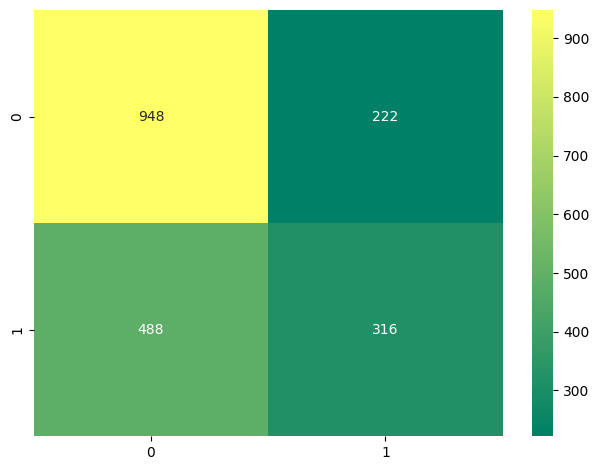

In [48]:
model(LinearDiscriminantAnalysis())

### LinearDiscriminantAnalysis for scaled data


Metrics:
Accuracy of LinearDiscriminantAnalysis() for train: 66.28%
Accuracy of LinearDiscriminantAnalysis() for test: 64.03%

Recall Score for LinearDiscriminantAnalysis(): 0.39
Precision Score for LinearDiscriminantAnalysis(): 0.59
F1 Score for LinearDiscriminantAnalysis(): 0.47

Confusion Matric:


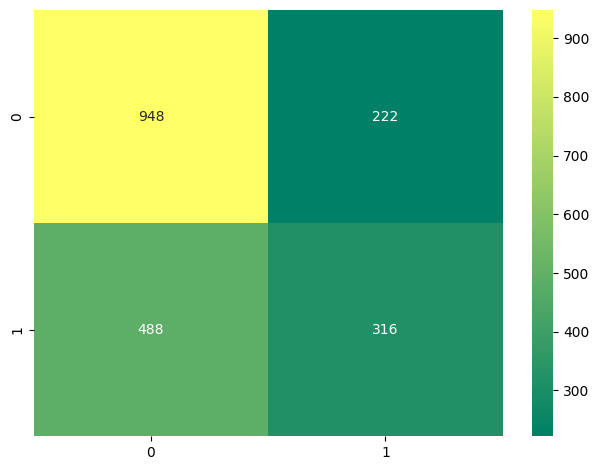

In [49]:
model_scaled_data(LinearDiscriminantAnalysis())

# LogisticsRegression for non-scaled data


Metrics:
Accuracy of LogisticRegression() for train: 60.79%
Accuracy of LogisticRegression() for test: 59.42%

Recall Score for LogisticRegression(): 0.33
Precision Score for LogisticRegression(): 0.50
F1 Score for LogisticRegression(): 0.40

Confusion Matric:


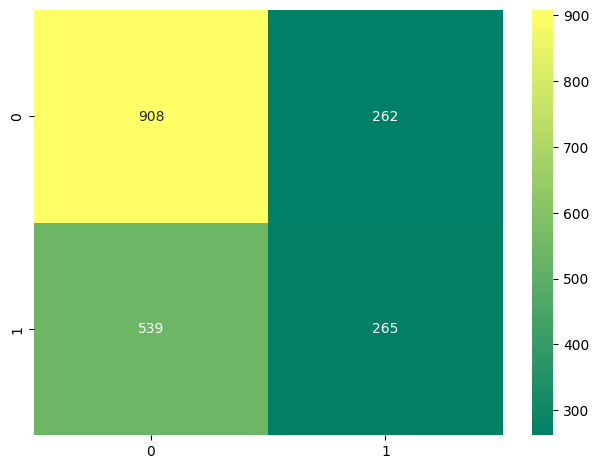

In [50]:
model(LogisticRegression())

# LogisticRegression for scaled data


Metrics:
Accuracy of LogisticRegression() for train: 66.27%
Accuracy of LogisticRegression() for test: 63.93%

Recall Score for LogisticRegression(): 0.39
Precision Score for LogisticRegression(): 0.59
F1 Score for LogisticRegression(): 0.47

Confusion Matric:


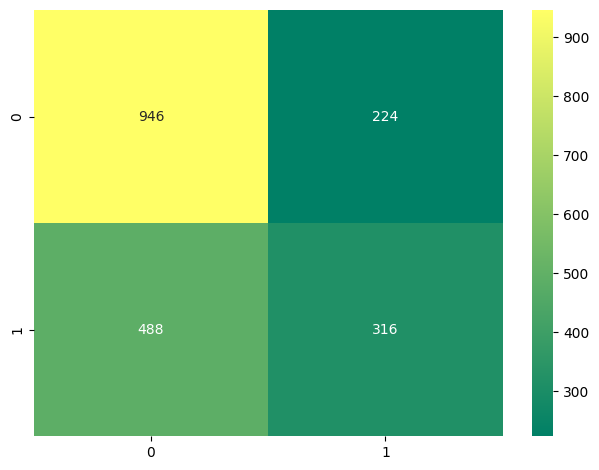

In [51]:
model_scaled_data(LogisticRegression())

# NaiveBayes for non-scaled data

In [52]:
# GaussianNB, MultinomialNB, BernoulliNB


Metrics:
Accuracy of GaussianNB() for train: 65.67%
Accuracy of GaussianNB() for test: 64.18%

Recall Score for GaussianNB(): 0.44
Precision Score for GaussianNB(): 0.58
F1 Score for GaussianNB(): 0.50

Confusion Matric:


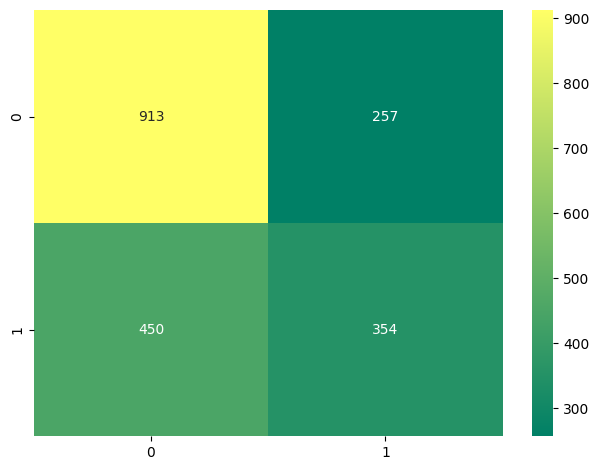

In [53]:
model(GaussianNB())


Metrics:
Accuracy of MultinomialNB() for train: 51.84%
Accuracy of MultinomialNB() for test: 50.91%

Recall Score for MultinomialNB(): 0.53
Precision Score for MultinomialNB(): 0.42
F1 Score for MultinomialNB(): 0.47

Confusion Matric:


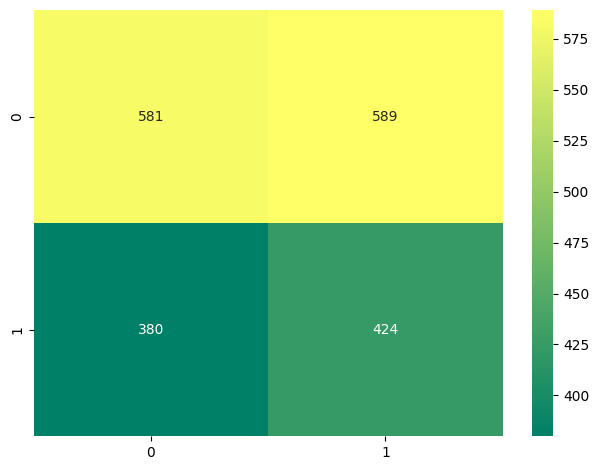

In [54]:
model(MultinomialNB())


Metrics:
Accuracy of BernoulliNB() for train: 58.22%
Accuracy of BernoulliNB() for test: 58.97%

Recall Score for BernoulliNB(): 0.32
Precision Score for BernoulliNB(): 0.49
F1 Score for BernoulliNB(): 0.39

Confusion Matric:


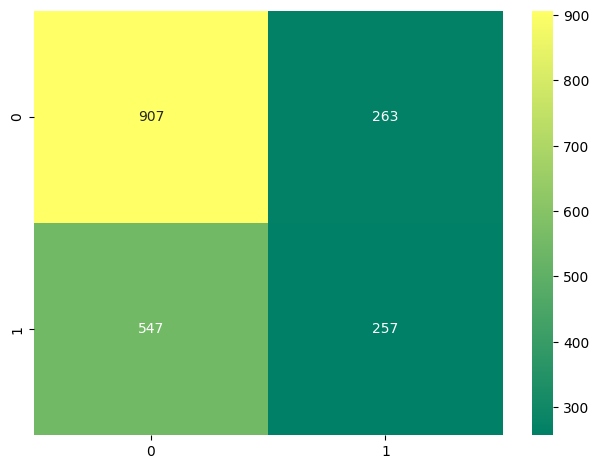

In [55]:
model(BernoulliNB())

# NaiveBayes for scaled data

In [56]:
# GaussianNB, MultinomialNB, BernoulliNB


Metrics:
Accuracy of GaussianNB() for train: 66.32%
Accuracy of GaussianNB() for test: 63.68%

Recall Score for GaussianNB(): 0.45
Precision Score for GaussianNB(): 0.57
F1 Score for GaussianNB(): 0.50

Confusion Matric:


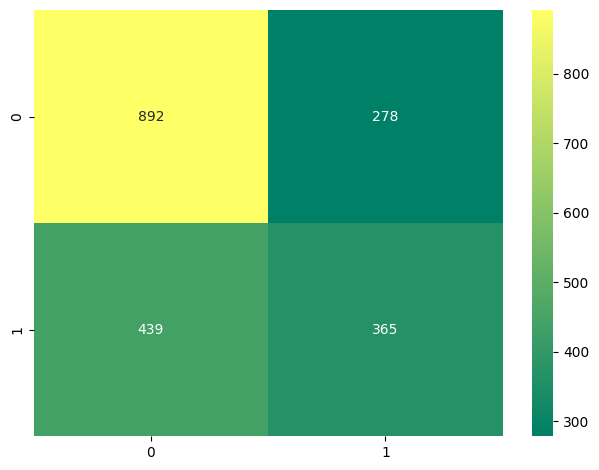

In [57]:
model_scaled_data(GaussianNB())


Metrics:
Accuracy of MultinomialNB() for train: 62.83%
Accuracy of MultinomialNB() for test: 61.80%

Recall Score for MultinomialNB(): 0.21
Precision Score for MultinomialNB(): 0.59
F1 Score for MultinomialNB(): 0.31

Confusion Matric:


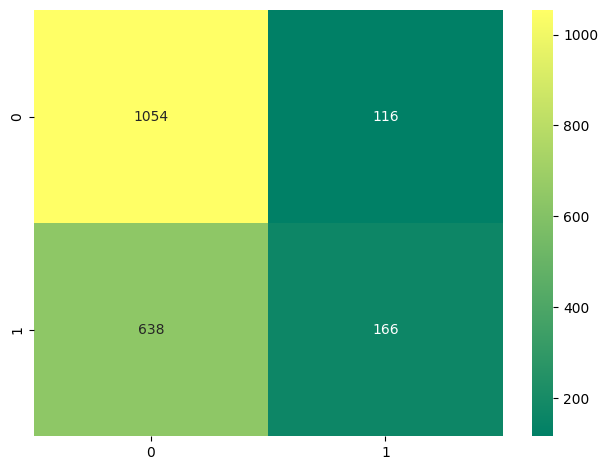

In [58]:
model_scaled_data(MultinomialNB())


Metrics:
Accuracy of BernoulliNB() for train: 58.31%
Accuracy of BernoulliNB() for test: 58.26%

Recall Score for BernoulliNB(): 0.27
Precision Score for BernoulliNB(): 0.48
F1 Score for BernoulliNB(): 0.34

Confusion Matric:


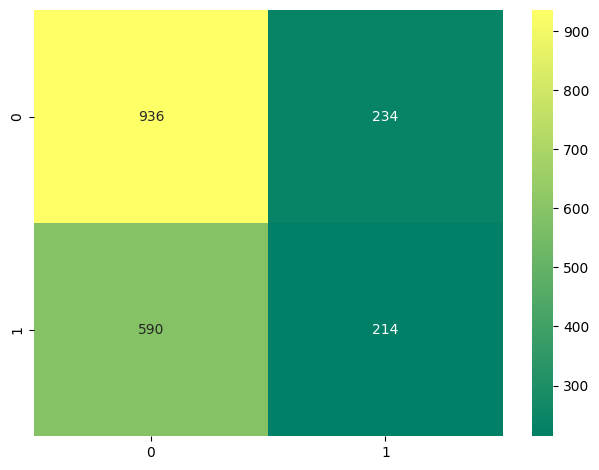

In [59]:
model_scaled_data(BernoulliNB())

# Statistical Machine Learning for non-scaled data

In [60]:
# KNeighborsClassifier
# DecisionTreeClassifier
# RandomForestClassifier
# XGBClassifier


Metrics:
Accuracy of KNeighborsClassifier() for train: 72.90%
Accuracy of KNeighborsClassifier() for test: 57.19%

Recall Score for KNeighborsClassifier(): 0.41
Precision Score for KNeighborsClassifier(): 0.47
F1 Score for KNeighborsClassifier(): 0.44

Confusion Matric:


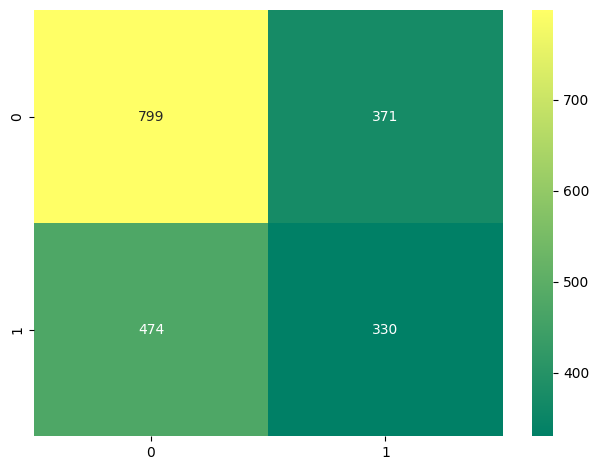

In [61]:
model(KNeighborsClassifier())


Metrics:
Accuracy of DecisionTreeClassifier() for train: 100.00%
Accuracy of DecisionTreeClassifier() for test: 77.25%

Recall Score for DecisionTreeClassifier(): 0.74
Precision Score for DecisionTreeClassifier(): 0.71
F1 Score for DecisionTreeClassifier(): 0.73

Confusion Matric:


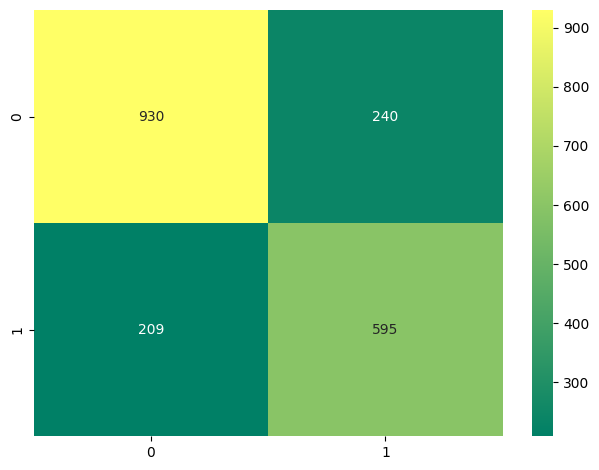

In [62]:
model(DecisionTreeClassifier())


Metrics:
Accuracy of RandomForestClassifier() for train: 100.00%
Accuracy of RandomForestClassifier() for test: 82.62%

Recall Score for RandomForestClassifier(): 0.71
Precision Score for RandomForestClassifier(): 0.84
F1 Score for RandomForestClassifier(): 0.77

Confusion Matric:


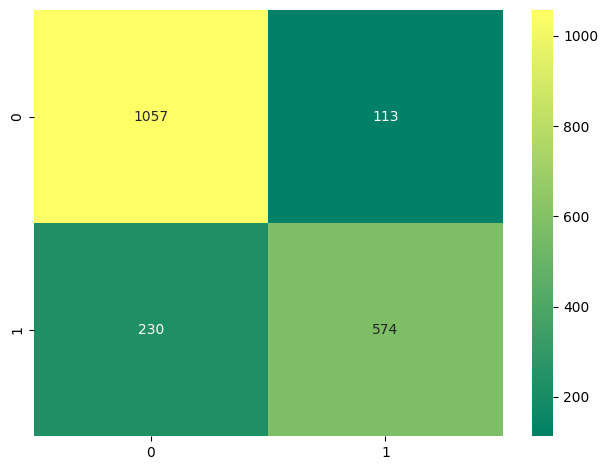

In [63]:
model(RandomForestClassifier())


Metrics:
Accuracy of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...) for train: 96.15%
Accuracy of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
         

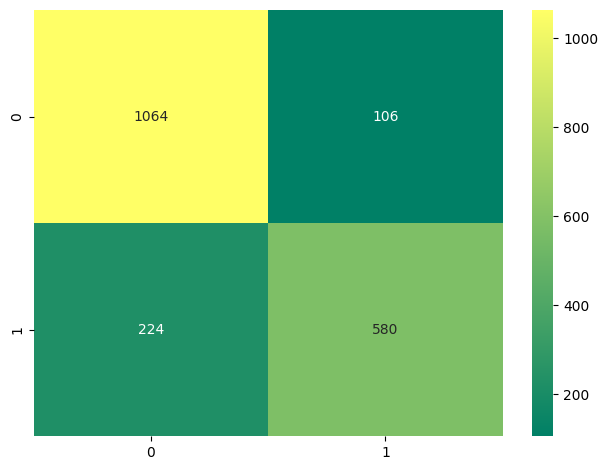

In [64]:
model(XGBClassifier())

### Statistical Machine Learning for scaled data

In [65]:
# KNeighborsClassifier
# DecisionTreeClassifier
# RandomForestClassifier
# XGBClassifier


Metrics:
Accuracy of KNeighborsClassifier() for train: 77.98%
Accuracy of KNeighborsClassifier() for test: 66.31%

Recall Score for KNeighborsClassifier(): 0.52
Precision Score for KNeighborsClassifier(): 0.60
F1 Score for KNeighborsClassifier(): 0.56

Confusion Matric:


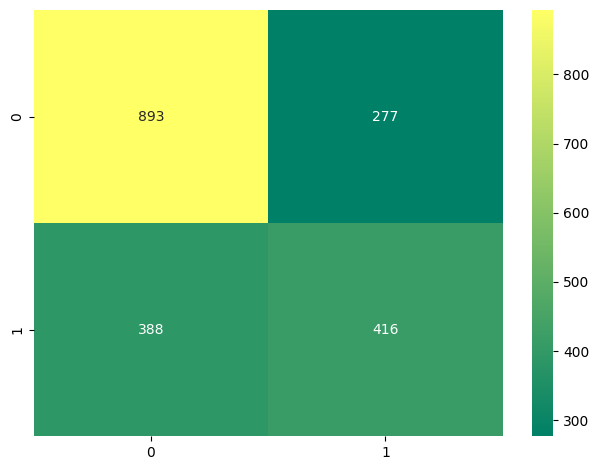

In [66]:
model_scaled_data(KNeighborsClassifier())


Metrics:
Accuracy of DecisionTreeClassifier() for train: 100.00%
Accuracy of DecisionTreeClassifier() for test: 77.46%

Recall Score for DecisionTreeClassifier(): 0.74
Precision Score for DecisionTreeClassifier(): 0.72
F1 Score for DecisionTreeClassifier(): 0.73

Confusion Matric:


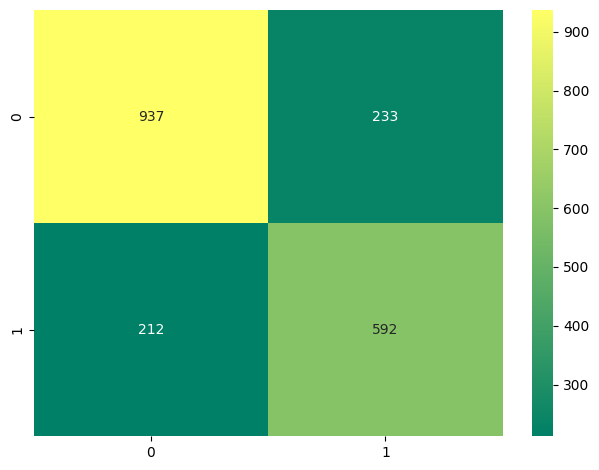

In [67]:
model_scaled_data(DecisionTreeClassifier())


Metrics:
Accuracy of RandomForestClassifier() for train: 100.00%
Accuracy of RandomForestClassifier() for test: 82.93%

Recall Score for RandomForestClassifier(): 0.71
Precision Score for RandomForestClassifier(): 0.85
F1 Score for RandomForestClassifier(): 0.77

Confusion Matric:


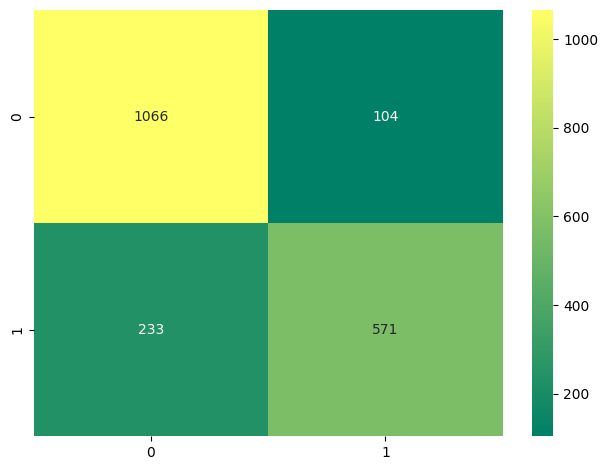

In [68]:
model_scaled_data(RandomForestClassifier())


Metrics:
Accuracy of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...) for train: 96.15%
Accuracy of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
         

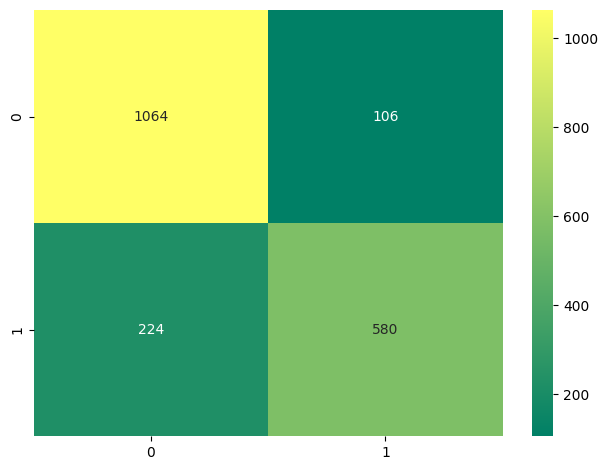

In [69]:
model_scaled_data(XGBClassifier())

### Model Comparison

In [70]:
stat_ml = ["LinearDiscriminant", "LogisticRegression","GaussianNB", "MultinomialNB", "BernoulliNB",
           "KNeighborsClassifier", "DecisionTreeClassifier", "RandomForestClassifier", "XGBClassifier"]

stat_df = pd.DataFrame({
    'Algorithms': stat_ml,
    'Training Accuracy': train_score,
    'Testing Accuracy': test_score
})
stat_df

,Algorithms,Training Accuracy,Testing Accuracy
0,LinearDiscriminant,66.278186,64.032421
1,LogisticRegression,60.793007,59.422492
2,GaussianNB,65.670129,64.184397
3,MultinomialNB,51.836838,50.911854
4,BernoulliNB,58.221434,58.966565
5,KNeighborsClassifier,72.903471,57.193516
6,DecisionTreeClassifier,100.000000,77.254306
7,RandomForestClassifier,100.000000,82.624113
8,XGBClassifier,96.148974,83.282675


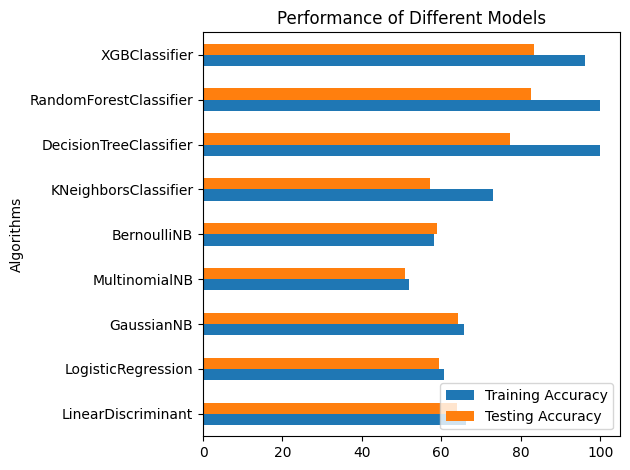

In [71]:
stat_df.plot(x='Algorithms', y=['Training Accuracy', 'Testing Accuracy'], kind='barh',
            title='Performance of Different Models')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [72]:
scaled_df = pd.DataFrame({
    'Algorithms': stat_ml,
    'Training Accuracy': train1_score,
    'Testing Accuracy': test1_score
})
scaled_df

,Algorithms,Training Accuracy,Testing Accuracy
0,LinearDiscriminant,66.278186,64.032421
1,LogisticRegression,66.265518,63.931104
2,GaussianNB,66.316190,63.677812
3,MultinomialNB,62.832531,61.803445
4,BernoulliNB,58.310109,58.257345
5,KNeighborsClassifier,77.983278,66.312057
6,DecisionTreeClassifier,100.000000,77.456940
7,RandomForestClassifier,100.000000,82.928065
8,XGBClassifier,96.148974,83.282675


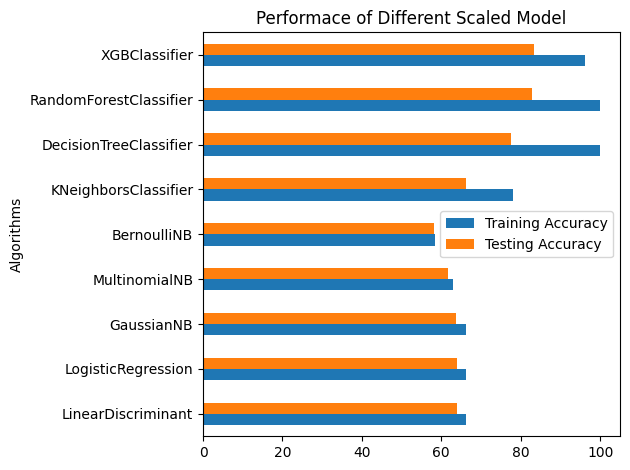

In [73]:
scaled_df.plot(x='Algorithms', y=['Training Accuracy', 'Testing Accuracy'], kind='barh',
              title='Performace of Different Scaled Model')

plt.tight_layout()
plt.show()

[*********************100%%**********************]  1 of 1 completed


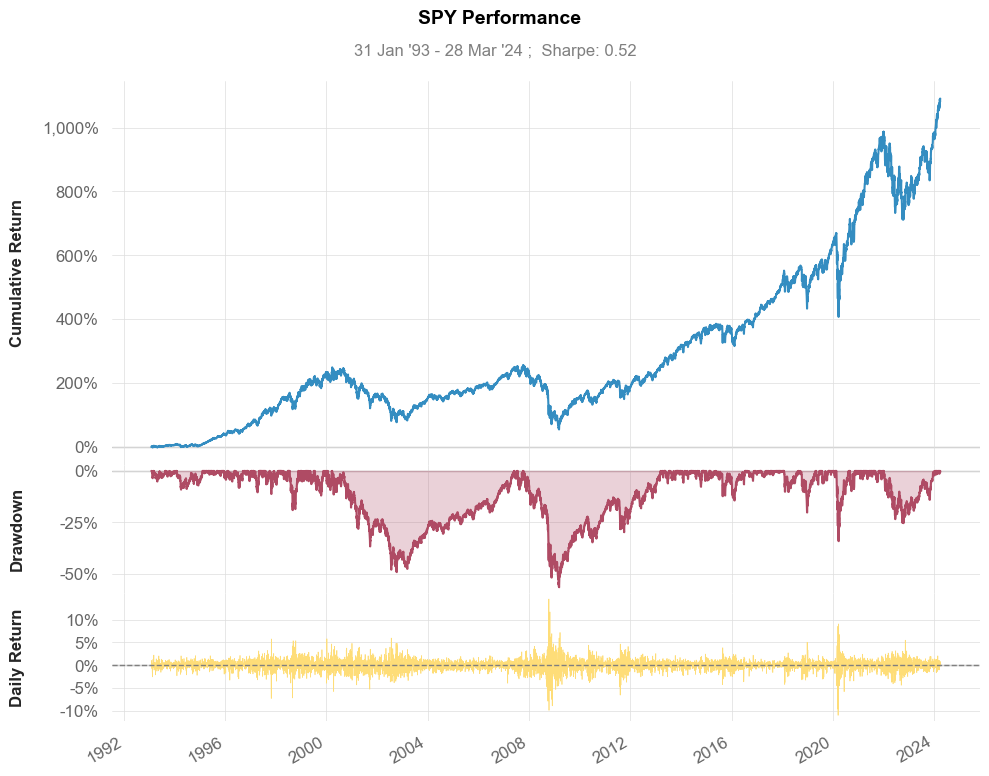

<Figure size 1000x600 with 0 Axes>

In [20]:
import quantstats as qs

stock = qs.utils.download_returns('SPY')
qs.plots.snapshot(stock, title='SPY Performance', show=True)

plt.tight_layout()
plt.show()